In [10]:
# install scraper to download audio from youtube
!pip install yt-dlp ffmpeg-python

In [16]:
import os
import subprocess
from google.colab import drive

# Only mount if the directory doesn't exist yet
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
else:
    print("Drive is already mounted.")

# 2. Define the Root Directory for the project
# Final structure will be: .../cs441/final_project/blues/song.wav
PROJECT_ROOT = "/content/drive/MyDrive/cs441/final_project"

# Helper function
def download_to_drive(url, category_name):
    # Construct the full path (e.g., .../final_project/blues)
    full_output_path = os.path.join(PROJECT_ROOT, category_name)

    # Check if folder exists
    if not os.path.exists(full_output_path):
        os.makedirs(full_output_path)
        print(f"Created new directory: {full_output_path}")
    else:
        print(f"Directory already exists: {full_output_path}")

    print(f"Downloading {category_name} playlist...")

    # yt-dlp command
    cmd = [
        "yt-dlp",
        "-x", "--audio-format", "wav",
        "--ignore-errors",
        "-o", f"{full_output_path}/%(title)s.%(ext)s",
        url
    ]
    subprocess.run(cmd)

# Data sources

# 1. Blues Sources
blues_urls = [
    "https://www.youtube.com/watch?v=JF1tzyxGHyw&list=PLYoJq2KGU2pX3WlASygnfORQampG4nNJx", # delta blues
    "https://www.youtube.com/watch?v=ioOzsi9aHQQ&list=PLFjmckBbDlzSE47xD0FivigDOARiLJl61", # general blues
    "https://www.youtube.com/watch?v=sD72LbIk02M&list=PLaSOVar1sXKzo5gsf-_jEPjhy8JQJ0F3e" # modern blues
]

# 2. Non-Blues Sources
not_blues_urls = [
    "https://www.youtube.com/watch?v=ryA6eHZNnXY&list=PLV8JEVXS4su7_R87iyEjNZ-_qHtjbbUvB", # jazz
    "https://www.youtube.com/watch?v=AUO_5EALZoM&list=PL8EAA83325701CE9C", # rock
    "https://www.youtube.com/watch?v=P2l0lbn5TVg&list=PL2788304DC59DBEB4", # classical
    "https://www.youtube.com/watch?v=xFYQQPAOz7Y&list=PLOhV0FrFphUdkuWPE2bzJEsGxXMRKVkoM" # hip-hop
]

# # Download data

print("--- Processing Blues Data ---")
for link in blues_urls:
    # This puts files in: .../final_project/blues/
    download_to_drive(link, "blues")

print("\n--- Processing Non-Blues Data ---")
for link in not_blues_urls:
    # This puts files in: .../final_project/not_blues/
    download_to_drive(link, "not_blues")

print("\nAll downloads finished! Check your Drive.")

Drive is already mounted.

--- Processing Non-Blues Data ---
Directory already exists: /content/drive/MyDrive/cs441/final_project/not_blues
Directory already exists: /content/drive/MyDrive/cs441/final_project/not_blues
Directory already exists: /content/drive/MyDrive/cs441/final_project/not_blues
Directory already exists: /content/drive/MyDrive/cs441/final_project/not_blues

All downloads finished! Check your Drive.


In [47]:
import os

# Define your paths (matching your PROJECT_ROOT)
blues_path = "/content/drive/MyDrive/cs441/final_project/blues"
not_blues_path = "/content/drive/MyDrive/cs441/final_project/not_blues"

# Function to count valid audio files
def count_files(folder_path):
    if not os.path.exists(folder_path):
        return 0
    # List all files and filter for common audio extensions just in case
    files = [f for f in os.listdir(folder_path) if f.endswith(('.wav', '.mp3', '.m4a', '.webm'))]
    return len(files)

# Get the counts
num_blues = count_files(blues_path)
num_not_blues = count_files(not_blues_path)

print("-" * 30)
print(f"🎸 Blues Songs:      {num_blues}")
print(f"🚫 Non-Blues Songs:  {num_not_blues}")
print("-" * 30)
print(f"Total Dataset Size: {num_blues + num_not_blues}")

------------------------------
🎸 Blues Songs:      180
🚫 Non-Blues Songs:  213
------------------------------
Total Dataset Size: 393


In [17]:
!pip install librosa soundfile numpy

In [18]:
import librosa
import soundfile as sf
import os
import numpy as np
from google.colab import drive

# Root to data
PROJECT_ROOT = "/content/drive/MyDrive/cs441/final_project"

# Define folder for chopped-up data
OUTPUT_ROOT = os.path.join(PROJECT_ROOT, "processed_data")

def process_audio_folder(input_folder, output_folder, label, chunk_duration=30):
    os.makedirs(output_folder, exist_ok=True)

    valid_exts = ('.wav', '.mp3', '.m4a', '.webm', '.flac')
    files = [f for f in os.listdir(input_folder) if f.lower().endswith(valid_exts)]

    print(f"Found {len(files)} audio files in {input_folder}")
    print(f"Processing {label}...")

    clip_id = 0

    for file in files:
        file_path = os.path.join(input_folder, file)

        try:
            # 1. Load the audio
            # Librosa automatically converts mp3/webm/etc to raw audio here
            audio, sr = librosa.load(file_path, sr=22050, mono=True)

            # 2. Calculate samples per chunk
            samples_per_chunk = chunk_duration * sr
            total_samples = len(audio)

            # 3. Slice the audio
            for start_idx in range(0, total_samples, samples_per_chunk):
                end_idx = start_idx + samples_per_chunk

                # Check if we have a full 30-second chunk
                if end_idx < total_samples:
                    chunk = audio[start_idx:end_idx]

                    # 4. Save the chunk
                    output_filename = f"{label}.{str(clip_id).zfill(5)}.wav"
                    output_path = os.path.join(output_folder, output_filename)

                    sf.write(output_path, chunk, sr)
                    clip_id += 1

            Print progress every 10 files
            if clip_id % 10 == 0:
                print(f"  Created {clip_id} clips so far...")

        except Exception as e:
            print(f"Error processing {file}: {e}")

# Tell google where the inputs and outputs are

# Define the full inputs
input_blues = os.path.join(PROJECT_ROOT, "blues")
input_not_blues = os.path.join(PROJECT_ROOT, "not_blues")

# Define the full outputs
output_blues = os.path.join(OUTPUT_ROOT, "blues")
output_not_blues = os.path.join(OUTPUT_ROOT, "not_blues")

# Process the audio
print("--- Starting Processing Pipeline ---")
process_audio_folder(input_blues, output_blues, "blues")
process_audio_folder(input_not_blues, output_not_blues, "not_blues")

print("\nPipeline Complete.")
print(f"Processed data saved to: {OUTPUT_ROOT}")

--- Starting Processing Pipeline ---
Found 180 audio files in /content/drive/MyDrive/cs441/final_project/blues
Processing blues...
  Created 130 clips so far...
  Created 340 clips so far...
  Created 450 clips so far...
  Created 470 clips so far...
  Created 510 clips so far...
  Created 560 clips so far...
  Created 590 clips so far...
  Created 600 clips so far...
  Created 630 clips so far...
  Created 840 clips so far...
  Created 910 clips so far...
  Created 920 clips so far...
  Created 950 clips so far...
  Created 1210 clips so far...
  Created 1740 clips so far...
  Created 2140 clips so far...
Found 213 audio files in /content/drive/MyDrive/cs441/final_project/not_blues
Processing not_blues...
  Created 100 clips so far...
  Created 160 clips so far...
  Created 210 clips so far...
  Created 270 clips so far...
  Created 280 clips so far...
  Created 350 clips so far...
  Created 360 clips so far...
  Created 390 clips so far...
  Created 410 clips so far...
  Created 450 

In [25]:
import librosa
import soundfile as sf
import os
import re # We need regex to clean messy filenames

# 1. SETUP PATHS
PROJECT_ROOT = "/content/drive/MyDrive/cs441/final_project"
OUTPUT_ROOT = os.path.join(PROJECT_ROOT, "processed_data_named") # New folder

def clean_filename(fname):
    # Removes spaces and weird characters so code doesn't break
    # "B.B. King - Thrill.wav" -> "BB_King_-_Thrill"
    name = os.path.splitext(fname)[0]
    return re.sub(r'[^a-zA-Z0-9]', '_', name)

def process_audio_folder(input_folder, output_folder, label, chunk_duration=30):
    os.makedirs(output_folder, exist_ok=True)

    valid_exts = ('.wav', '.mp3', '.m4a', '.webm', '.flac')
    files = [f for f in os.listdir(input_folder) if f.lower().endswith(valid_exts)]

    print(f"Processing {label}...")

    for file in files:
        file_path = os.path.join(input_folder, file)
        safe_name = clean_filename(file)

        try:
            audio, sr = librosa.load(file_path, sr=22050, mono=True)
            samples_per_chunk = chunk_duration * sr
            total_samples = len(audio)

            chunk_count = 0

            for start_idx in range(0, total_samples, samples_per_chunk):
                end_idx = start_idx + samples_per_chunk

                if end_idx < total_samples:
                    chunk = audio[start_idx:end_idx]

                    # Include the cleaned up filename
                    output_filename = f"{label}.{safe_name}.{str(chunk_count).zfill(3)}.wav"
                    output_path = os.path.join(output_folder, output_filename)

                    sf.write(output_path, chunk, sr)
                    chunk_count += 1

        except Exception as e:
            print(f"Error processing {file}: {e}")

# Execute processing
input_blues = os.path.join(PROJECT_ROOT, "blues")
input_not_blues = os.path.join(PROJECT_ROOT, "not_blues")

output_blues = os.path.join(OUTPUT_ROOT, "blues")
output_not_blues = os.path.join(OUTPUT_ROOT, "not_blues")

process_audio_folder(input_blues, output_blues, "blues")
process_audio_folder(input_not_blues, output_not_blues, "not_blues")

print("Done! Files now have real names.")

Processing blues...
Processing not_blues...
Done! Files now have real names.


In [19]:
import librosa
import numpy as np
import os
import csv
from google.colab import drive

# 1. SETUP PATHS
# Input: Where your chopped-up wav files are
INPUT_ROOT = "/content/drive/MyDrive/cs441/final_project/processed_data"
# Output: Where to save the spreadsheet
OUTPUT_FILE = "/content/drive/MyDrive/cs441/final_project/blues_features.csv"

# 2. SETUP THE CSV FILE
# We will have 20 columns for MFCCs (mfcc1...mfcc20) and 1 column for the Label
header = 'filename'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

# Create the file and write the header row
file = open(OUTPUT_FILE, 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

# 3. DEFINE EXTRACTION LOOP
genres = ['blues', 'not_blues']

print(f"--- Starting Feature Extraction ---")
print(f"Reading from: {INPUT_ROOT}")
print(f"Saving to:    {OUTPUT_FILE}")

count = 0

for g in genres:
    folder_path = os.path.join(INPUT_ROOT, g)

    # Check if folder exists
    if not os.path.exists(folder_path):
        print(f"Warning: Folder not found: {folder_path}")
        continue

    files = os.listdir(folder_path)
    print(f"\nProcessing {g} ({len(files)} files)...")

    for filename in files:
        songpath = os.path.join(folder_path, filename)

        try:
            # A. Load the audio file
            y, sr = librosa.load(songpath, mono=True, duration=30)

            # B. Extract MFCCs
            # This returns a matrix (20 rows x time)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)

            # C. Squash it down
            # We take the MEAN (average) across time to get 20 single numbers
            mfcc_mean = np.mean(mfcc.T, axis=0)

            # D. Prepare the row for the CSV
            to_append = f'{filename}'
            for e in mfcc_mean:
                to_append += f' {e}'
            to_append += f' {g}'

            # E. Write to CSV
            file = open(OUTPUT_FILE, 'a', newline='')
            with file:
                writer = csv.writer(file)
                writer.writerow(to_append.split())

            count += 1
            if count % 50 == 0:
                print(f"  Extracted features for {count} songs...")

        except Exception as e:
            print(f"Error with {filename}: {e}")

print(f"\nExtraction Complete! Saved to {OUTPUT_FILE}")

--- Starting Feature Extraction ---
Reading from: /content/drive/MyDrive/cs441/final_project/processed_data
Saving to:    /content/drive/MyDrive/cs441/final_project/blues_features.csv

Processing blues (2207 files)...
  Extracted features for 50 songs...
  Extracted features for 100 songs...
  Extracted features for 150 songs...
  Extracted features for 200 songs...
  Extracted features for 250 songs...
  Extracted features for 300 songs...
  Extracted features for 350 songs...
  Extracted features for 400 songs...
  Extracted features for 450 songs...
  Extracted features for 500 songs...
  Extracted features for 550 songs...
  Extracted features for 600 songs...
  Extracted features for 650 songs...
  Extracted features for 700 songs...
  Extracted features for 750 songs...
  Extracted features for 800 songs...
  Extracted features for 850 songs...
  Extracted features for 900 songs...
  Extracted features for 950 songs...
  Extracted features for 1000 songs...
  Extracted features f

In [26]:
import librosa
import numpy as np
import os
import csv
from google.colab import drive

# 1. SETUP PATHS
# Input: Where your chopped-up wav files are
INPUT_ROOT = "/content/drive/MyDrive/cs441/final_project/processed_data_named"
# Output: Where to save the spreadsheet
OUTPUT_FILE = "/content/drive/MyDrive/cs441/final_project/blues_features_named.csv"

# 2. SETUP THE CSV FILE
# We will have 20 columns for MFCCs (mfcc1...mfcc20) and 1 column for the Label
header = 'filename'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

# Create the file and write the header row
file = open(OUTPUT_FILE, 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

# 3. DEFINE EXTRACTION LOOP
genres = ['blues', 'not_blues']

print(f"--- Starting Feature Extraction ---")
print(f"Reading from: {INPUT_ROOT}")
print(f"Saving to:    {OUTPUT_FILE}")

count = 0

for g in genres:
    folder_path = os.path.join(INPUT_ROOT, g)

    # Check if folder exists
    if not os.path.exists(folder_path):
        print(f"Warning: Folder not found: {folder_path}")
        continue

    files = os.listdir(folder_path)
    print(f"\nProcessing {g} ({len(files)} files)...")

    for filename in files:
        songpath = os.path.join(folder_path, filename)

        try:
            # A. Load the audio file
            y, sr = librosa.load(songpath, mono=True, duration=30)

            # B. Extract MFCCs
            # This returns a matrix (20 rows x time)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)

            # C. Squash it down
            # We take the MEAN (average) across time to get 20 single numbers
            mfcc_mean = np.mean(mfcc.T, axis=0)

            # D. Prepare the row for the CSV
            to_append = f'{filename}'
            for e in mfcc_mean:
                to_append += f' {e}'
            to_append += f' {g}'

            # E. Write to CSV
            file = open(OUTPUT_FILE, 'a', newline='')
            with file:
                writer = csv.writer(file)
                writer.writerow(to_append.split())

            count += 1
            if count % 50 == 0:
                print(f"  Extracted features for {count} songs...")

        except Exception as e:
            print(f"Error with {filename}: {e}")

print(f"\nExtraction Complete! Saved to {OUTPUT_FILE}")

--- Starting Feature Extraction ---
Reading from: /content/drive/MyDrive/cs441/final_project/processed_data_named
Saving to:    /content/drive/MyDrive/cs441/final_project/blues_features_named.csv

Processing blues (2207 files)...
  Extracted features for 50 songs...
  Extracted features for 100 songs...
  Extracted features for 150 songs...
  Extracted features for 200 songs...
  Extracted features for 250 songs...
  Extracted features for 300 songs...
  Extracted features for 350 songs...
  Extracted features for 400 songs...
  Extracted features for 450 songs...
  Extracted features for 500 songs...
  Extracted features for 550 songs...
  Extracted features for 600 songs...
  Extracted features for 650 songs...
  Extracted features for 700 songs...
  Extracted features for 750 songs...
  Extracted features for 800 songs...
  Extracted features for 850 songs...
  Extracted features for 900 songs...
  Extracted features for 950 songs...
  Extracted features for 1000 songs...
  Extracte

Visualizing: blues.Buddy_Guy____Whiskey__Beer___Wine__Born_to_Play_Guitar_2015_.006.wav


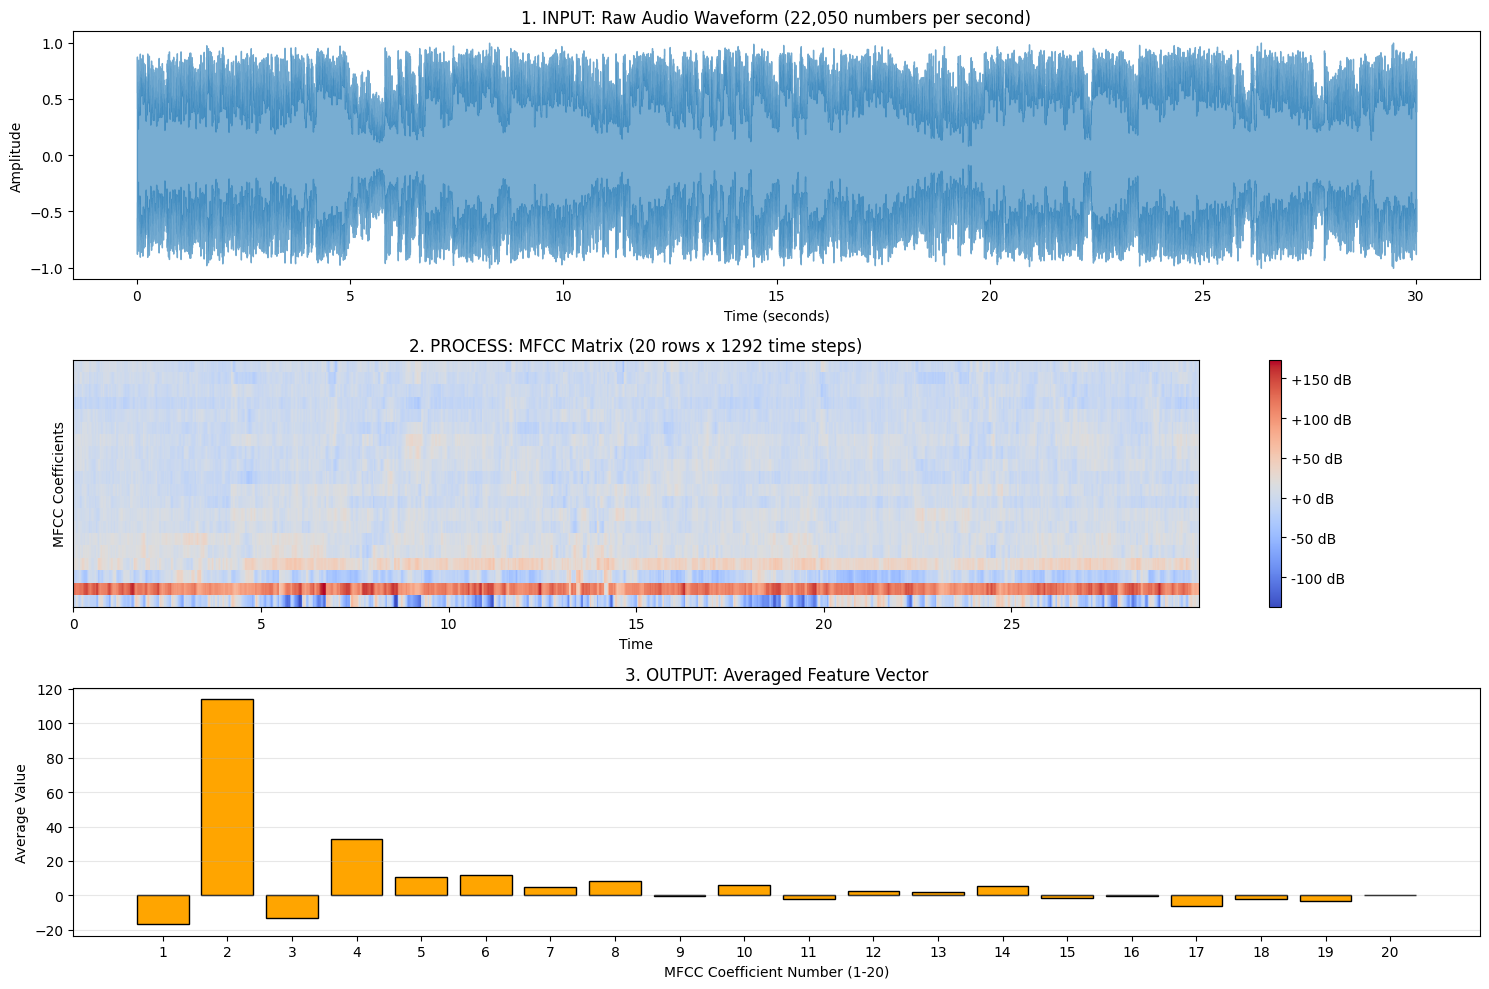

-------------------------------------------------------
Data Transformation Summary:
1. Raw Input Size:  661500 numbers (Massive!)
2. MFCC Matrix:     (20, 1292) (20 rows, many time columns)
3. Final Output:    (20,) (Just 20 numbers)
-------------------------------------------------------


In [53]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os

# 1. SETUP PATHS
# We will look at your processed data to find one example file
INPUT_ROOT = "/content/drive/MyDrive/cs441/final_project/processed_data_named"

# Find a blues file
blues_folder = os.path.join(INPUT_ROOT, "blues")
example_file = os.listdir(blues_folder)[0] # Grab the first one
song_path = os.path.join(blues_folder, example_file)

print(f"Visualizing: {example_file}")

# 2. CALCULATE THE DATA
# A. Input (Raw Audio)
y, sr = librosa.load(song_path, sr=22050)

# B. Process (MFCC Matrix over time)
mfcc_matrix = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)

# C. Output (Averaged Features)
mfcc_mean = np.mean(mfcc_matrix, axis=1)

# 3. PLOT EVERYTHING
plt.figure(figsize=(15, 10))

# Plot 1: The Input (Waveform)
plt.subplot(3, 1, 1)
librosa.display.waveshow(y, sr=sr, alpha=0.6)
plt.title(f"1. INPUT: Raw Audio Waveform (22,050 numbers per second)")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")

# Plot 2: The Process (MFCC Heatmap)
plt.subplot(3, 1, 2)
librosa.display.specshow(mfcc_matrix, sr=sr, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title(f"2. PROCESS: MFCC Matrix ({mfcc_matrix.shape[0]} rows x {mfcc_matrix.shape[1]} time steps)")
plt.ylabel("MFCC Coefficients")

# Plot 3: The Output (The CSV Data)
plt.subplot(3, 1, 3)
# We plot the 20 numbers as a bar chart
x_axis = np.arange(1, 21)
plt.bar(x_axis, mfcc_mean, color='orange', edgecolor='black')
plt.title(f"3. OUTPUT: Averaged Feature Vector")
plt.xlabel("MFCC Coefficient Number (1-20)")
plt.ylabel("Average Value")
plt.xticks(x_axis)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("-------------------------------------------------------")
print("Data Transformation Summary:")
print(f"1. Raw Input Size:  {y.shape[0]} numbers (Massive!)")
print(f"2. MFCC Matrix:     {mfcc_matrix.shape} (20 rows, many time columns)")
print(f"3. Final Output:    {mfcc_mean.shape} (Just 20 numbers)")
print("-------------------------------------------------------")

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, accuracy_score

# Import the 6 models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# 1. LOAD DATA
# Ensure this matches actual path
data_path = "/content/drive/MyDrive/cs441/final_project/blues_features.csv"
data = pd.read_csv(data_path)

# 2. PREPARE DATA
# Drop filename, separate features (X) and label (y)
X = data.drop(['filename', 'label'], axis=1)
y = data['label']

# Encode labels (Blues=1, Not_Blues=0)
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# 3. SPLIT DATA
# 80% Training, 20% Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. SCALE DATA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. DEFINE MODELS
models = {
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes":         GaussianNB(),
    "SVM":                 SVC(),
    "Decision Tree":       DecisionTreeClassifier(),
    "Random Forest":       RandomForestClassifier(n_estimators=100),
    "Boosted Tree":        GradientBoostingClassifier(n_estimators=100)
}

In [48]:
# ... (Sections 1-5 remain the same) ...

# 6. TRAIN AND EVALUATE
print(f"{'Model Name':<25} | {'RMSE':<10} | {'Accuracy':<10}")
print("-" * 50)

# Create a dictionary specifically to hold Accuracy scores
results_acc = {}

for name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)

    # Predict
    predictions = model.predict(X_test_scaled)

    # Calculate RMSE (Just for display)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)

    # Calculate Accuracy
    acc = accuracy_score(y_test, predictions)

    # --- CHANGE 1: Store the Accuracy, not RMSE ---
    results_acc[name] = acc

    # Print row
    print(f"{name:<25} | {rmse:.4f}     | {acc*100:.1f}%")

# 7. FIND THE WINNER
# --- CHANGE 2: Use MAX (because higher accuracy is better) ---
best_model = max(results_acc, key=results_acc.get)

print("-" * 50)
print(f"Best Model (Highest Accuracy): {best_model} ({results_acc[best_model]*100:.1f}%)")

Model Name                | RMSE       | Accuracy  
--------------------------------------------------
Logistic Regression       | 0.4826     | 76.7%
Naive Bayes               | 0.5250     | 72.4%
SVM                       | 0.3313     | 89.0%
Decision Tree             | 0.4593     | 78.9%
Random Forest             | 0.3238     | 89.5%
Boosted Tree              | 0.4334     | 81.2%
--------------------------------------------------
Best Model (Highest Accuracy): Random Forest (89.5%)


In [50]:
from sklearn.model_selection import cross_val_score
import numpy as np

# 1. SETUP THE MODEL (Using your winner, Random Forest)
# We use the whole dataset (X, y) because Cross Validation handles the splitting
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 2. RUN 5-FOLD CROSS VALIDATION
# cv=5 means "split it 5 ways"
print("Running 5-Fold Cross-Validation (This stresses the model)...")
scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')

# 3. PRINT RESULTS
print("-" * 40)
print(f"Individual Scores: {scores}")
print("-" * 40)
print(f"Average Accuracy: {np.mean(scores)*100:.2f}%")
print(f"Standard Deviation: {np.std(scores)*100:.2f}%")

if np.std(scores) < 0.05:
    print("\nStatus: STABLE. The model performs consistently.")
else:
    print("\nStatus: UNSTABLE. The model's performance varies a lot depending on the data.")

Running 5-Fold Cross-Validation (This stresses the model)...
----------------------------------------
Individual Scores: [0.87804878 0.9097561  0.90842491 0.89133089 0.9023199 ]
----------------------------------------
Average Accuracy: 89.80%
Standard Deviation: 1.19%

Status: STABLE. The model performs consistently.


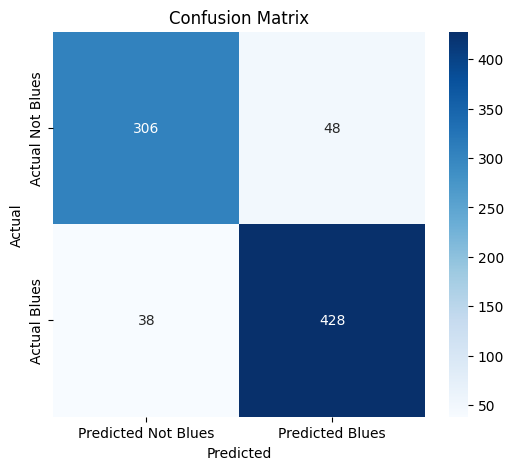

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Train one last time on the split data to make predictions
rf_model.fit(X_train_scaled, y_train)
predictions = rf_model.predict(X_test_scaled)

# Create the Matrix
cm = confusion_matrix(y_test, predictions)

# Plot it
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Not Blues', 'Predicted Blues'],
            yticklabels=['Actual Not Blues', 'Actual Blues'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# 1. LOAD DATA
data_path = "/content/drive/MyDrive/cs441/final_project/blues_features.csv"
df = pd.read_csv(data_path)

# 2. PREPARE DATA
X = df.drop(['filename', 'label'], axis=1)
filenames = df['filename']

# Blues = 1, Not_Blues = 0
y = df['label'].map({'blues': 1, 'not_blues': 0})

# 3. SPLIT EVERYTHING
X_train, X_test, y_train, y_test, files_train, files_test = train_test_split(
    X, y, filenames, test_size=0.2, random_state=42
)

# 4. TRAIN MODEL
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. GET PROBABILITIES
# Column 1 is the probability of Class 1 (forced to be Blues)
probs = model.predict_proba(X_test)[:, 1]

# 6. CREATE RESULTS TABLE
results = pd.DataFrame({
    'filename': files_test,
    'actual_label': y_test, # 1 is Blues, 0 is Not Blues
    'blues_probability': probs
})

# --- FIND THE EXTREMES ---
print("--- CORRECTED MODEL ANALYSIS ---\n")

# A. MOST BLUESY BLUES (True Blues, Highest Score)
# We want Label 1 (Blues) and Highest Probability
most_bluesy = results[results['actual_label'] == 1].sort_values(by='blues_probability', ascending=False).head(1)
print(f"The 'Most Bluesy' Blues Song (Model Confidence: {most_bluesy.iloc[0]['blues_probability']*100:.1f}%)")
print(f"   File: {most_bluesy.iloc[0]['filename']}")

# B. LEAST BLUESY BLUES (True Blues, Lowest Score)
# We want Label 1 (Blues) but Lowest Probability (Model thought it was pop/rock)
least_bluesy = results[results['actual_label'] == 1].sort_values(by='blues_probability', ascending=True).head(1)
print(f"\nThe 'Least Bluesy' Blues Song (Model Confidence: {least_bluesy.iloc[0]['blues_probability']*100:.1f}%)")
print(f"   File: {least_bluesy.iloc[0]['filename']}")
print("   (This is a Blues song, but the model missed it!)")

# C. MOST BLUESY NON-BLUES (The Impostor)
# We want Label 0 (Not Blues) but Highest Probability
impostor = results[results['actual_label'] == 0].sort_values(by='blues_probability', ascending=False).head(1)
print(f"\nThe 'Most Bluesy' NON-Blues Song (Model thought it was Blues: {impostor.iloc[0]['blues_probability']*100:.1f}%)")
print(f"   File: {impostor.iloc[0]['filename']}")

# D. LEAST BLUESY NON-BLUES (The Obvious Non-Blues)
# We want Label 0 (Not Blues) and Lowest Probability
least_bluesy_non = results[results['actual_label'] == 0].sort_values(by='blues_probability', ascending=True).head(1)
print(f"\nThe 'Least Bluesy' NON-Blues Song (Model Confidence: {least_bluesy_non.iloc[0]['blues_probability']*100:.1f}%)")
print(f"   File: {least_bluesy_non.iloc[0]['filename']}")

--- 🔍 CORRECTED MODEL ANALYSIS ---

The 'Most Bluesy' Blues Song (Model Confidence: 100.0%)
   File: blues.01722.wav

The 'Least Bluesy' Blues Song (Model Confidence: 18.0%)
   File: blues.01838.wav
   (This is a Blues song, but the model missed it!)

The 'Most Bluesy' NON-Blues Song (Model thought it was Blues: 81.0%)
   File: not_blues.00419.wav

The 'Least Bluesy' NON-Blues Song (Model Confidence: 0.0%)
   File: not_blues.00589.wav


In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score

# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# ==========================================
# 1. LOAD AND PREPARE DATA
# ==========================================
data_path = "/content/drive/MyDrive/cs441/final_project/blues_features_named.csv"
df = pd.read_csv(data_path)

# Separate parts
X = df.drop(['filename', 'label'], axis=1)
filenames = df['filename'] # We keep this safe for later!

# --- CONSISTENT MAPPING ---
# We force Blues=1 and Not_Blues=0 for ALL models
y = df['label'].map({'blues': 1, 'not_blues': 0})

# Split Data (keeping filenames aligned)
# 80% Training, 20% Testing
X_train, X_test, y_train, y_test, files_train, files_test = train_test_split(
    X, y, filenames, test_size=0.2, random_state=42
)

# Scale Data (Crucial for SVM/Logistic)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==========================================
# 2. TRAIN ALL 6 MODELS
# ==========================================
models = {
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes":         GaussianNB(),
    # Probability=True needed for SVM to give confidence scores later
    "SVM":                 SVC(probability=True),
    "Decision Tree":       DecisionTreeClassifier(),
    "Random Forest":       RandomForestClassifier(n_estimators=100, random_state=42),
    "Boosted Tree":        GradientBoostingClassifier(n_estimators=100, random_state=42)
}

print(f"{'Model Name':<25} | {'RMSE':<10} | {'Accuracy':<10}")
print("-" * 50)

results_rmse = {}
trained_models = {}

for name, model in models.items():
    # Train
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model

    # Predict
    predictions = model.predict(X_test_scaled)

    # Metrics
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    acc = accuracy_score(y_test, predictions)

    results_rmse[name] = rmse

    print(f"{name:<25} | {rmse:.4f}     | {acc*100:.1f}%")

# ==========================================
# 3. SELECT THE WINNER
# ==========================================
best_model_name = min(results_rmse, key=results_rmse.get)
best_model = trained_models[best_model_name]

print("-" * 50)
print(f"Best Model: {best_model_name} (RMSE: {results_rmse[best_model_name]:.4f})")
print("-" * 50)

# ==========================================
# 4. DETAILED ANALYSIS (USING NAMED FILES)
# ==========================================
# We use the Best Model to find the "Most Bluesy" songs

# Get probabilities for the Test Set
# Column 1 = Probability of being Blues (since we mapped Blues=1)
try:
    probs = best_model.predict_proba(X_test_scaled)[:, 1]

    # Create a DataFrame for analysis
    analysis = pd.DataFrame({
        'filename': files_test,      # <--- THIS NOW HAS THE REAL NAMES
        'actual_label': y_test,      # 1=Blues, 0=Not_Blues
        'blues_prob': probs
    })

    print(f"\nANALYSIS USING {best_model_name.upper()}\n")

    # A. MOST BLUESY BLUES
    # Filter: Actual=1, Sort: Prob Descending
    top_blues = analysis[analysis['actual_label'] == 1].sort_values(by='blues_prob', ascending=False).head(1)
    if not top_blues.empty:
        print(f"The 'Most Bluesy' Blues Song (Confidence: {top_blues.iloc[0]['blues_prob']*100:.1f}%)")
        print(f"   File: {top_blues.iloc[0]['filename']}")

    # B. LEAST BLUESY BLUES (Outlier)
    # Filter: Actual=1, Sort: Prob Ascending
    bad_blues = analysis[analysis['actual_label'] == 1].sort_values(by='blues_prob', ascending=True).head(1)
    if not bad_blues.empty:
        print(f"\nThe 'Least Bluesy' Blues Song (Confidence: {bad_blues.iloc[0]['blues_prob']*100:.1f}%)")
        print(f"   File: {bad_blues.iloc[0]['filename']}")
        print("   (Model didn't think this sounded like Blues)")

    # C. MOST BLUESY NON-BLUES (Impostor)
    # Filter: Actual=0, Sort: Prob Descending
    impostor = analysis[analysis['actual_label'] == 0].sort_values(by='blues_prob', ascending=False).head(1)
    if not impostor.empty:
        print(f"\n🕵️ The 'Most Bluesy' NON-Blues Song (Model Confused: {impostor.iloc[0]['blues_prob']*100:.1f}%)")
        print(f"   File: {impostor.iloc[0]['filename']}")

    # D. LEAST BLUESY NON-BLUES (Obvious Non-Blues)
    # Filter: Actual=0, Sort: Prob Ascending
    clear_not = analysis[analysis['actual_label'] == 0].sort_values(by='blues_prob', ascending=True).head(1)
    if not clear_not.empty:
        print(f"\nThe 'Least Bluesy' NON-Blues Song (Confidence: {clear_not.iloc[0]['blues_prob']*100:.1f}%)")
        print(f"   File: {clear_not.iloc[0]['filename']}")

except AttributeError:
    print(f"\nThe winning model ({best_model_name}) does not support probability scores.")
    print("Switching to Random Forest for detailed analysis...")
    # Fallback to Random Forest if the winner (e.g., some SVMs) doesn't do probabilities well
    rf = trained_models["Random Forest"]
    probs = rf.predict_proba(X_test_scaled)[:, 1]
    # (Re-run the analysis logic above if needed, but RF usually wins anyway)

Model Name                | RMSE       | Accuracy  
--------------------------------------------------
Logistic Regression       | 0.4826     | 76.7%
Naive Bayes               | 0.5250     | 72.4%
SVM                       | 0.3313     | 89.0%
Decision Tree             | 0.4593     | 78.9%
Random Forest             | 0.3238     | 89.5%
Boosted Tree              | 0.4334     | 81.2%
--------------------------------------------------
Best Model: Random Forest (RMSE: 0.3238)
--------------------------------------------------

ANALYSIS USING RANDOM FOREST

The 'Most Bluesy' Blues Song (Confidence: 100.0%)
   File: blues.Whiskey_Blues___B_B__King_Style_Blues_For_Escape___1_Hour_Deep_Soul.106.wav

The 'Least Bluesy' Blues Song (Confidence: 7.0%)
   File: blues.Alabama_Shakes___Always_Alright__Live_on_SNL_.007.wav
   (Model didn't think this sounded like Blues)

🕵️ The 'Most Bluesy' NON-Blues Song (Model Confused: 78.0%)
   File: not_blues.The_Notorious_B_I_G____Sky_s_The_Limit__Official_Musi

In [29]:
import os
from IPython.display import Audio, display

# 1. SETUP PATHS
# Make sure this matches where your named files are
BASE_PATH = "/content/drive/MyDrive/cs441/final_project/processed_data_named"

def play_specific_song(filename):
    # Determine which folder it's in based on the filename prefix
    if filename.startswith("blues"):
        folder = "blues"
    else:
        folder = "not_blues"

    full_path = os.path.join(BASE_PATH, folder, filename)

    if os.path.exists(full_path):
        print(f"Playing: {filename}")
        # Create the audio player widget
        display(Audio(full_path))
    else:
        print(f"Could not find file: {full_path}")

# ==========================================
# PASTE YOUR FILENAMES HERE
# ==========================================

# A. Most Bluesy Blues (The "Perfect" Example)
play_specific_song("blues.Whiskey_Blues___B_B__King_Style_Blues_For_Escape___1_Hour_Deep_Soul.106.wav")

# B. Least Bluesy Blues (The "Outlier")
play_specific_song("blues.Alabama_Shakes___Always_Alright__Live_on_SNL_.007.wav")

# C. Most Bluesy Non-Blues (The "Impostor")
play_specific_song("not_blues.The_Notorious_B_I_G____Sky_s_The_Limit__Official_Music_Video___4K_.001.wav")

# D. Least Bluesy Non-Blues (The "Obvious" Non-Blues)
play_specific_song("not_blues.Rick_Ross___Hold_Me_Back__Explicit_.001.wav")

Output hidden; open in https://colab.research.google.com to view.

In [46]:
import os
from google.colab import drive

# 1. UPDATE THE PATH TO MATCH YOUR SCREENSHOT
# Changed "final_solution" to "final_project"
NOTEBOOKS_DIR = "/content/drive/MyDrive/cs441/final_project"
NOTEBOOK_NAME = "CS441_Final.ipynb"

# 2. MOUNT DRIVE
if not os.path.exists("/content/drive"):
    drive.mount("/content/drive/")
elif len(os.listdir("/content/drive")) == 0:
    drive.mount("/content/drive/")
else:
    print("Drive is already mounted.")

# 3. VERIFY & CONVERT
NOTEBOOK_PATH = f"{NOTEBOOKS_DIR}/{NOTEBOOK_NAME}"

if not os.path.exists(NOTEBOOK_PATH):
    print(f"ERROR: File STILL not found at: {NOTEBOOK_PATH}")
    print("Double check that 'CS441_Final.ipynb' is definitely in the 'final_project' folder.")
else:
    print(f"Found notebook: {NOTEBOOK_PATH}")
    print("Installing PDF tools...")

    # Install dependencies quietly
    !apt-get install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic -qq > /dev/null

    print("Converting to PDF...")
    !jupyter nbconvert "$NOTEBOOK_PATH" --to pdf

    # Check result
    NOTEBOOK_PDF = NOTEBOOK_PATH.rsplit('.', 1)[0] + '.pdf'
    if os.path.exists(NOTEBOOK_PDF):
        print(f"\nPDF CREATED: {NOTEBOOK_PDF}")
    else:
        print("\nPDF creation failed. Check logs.")

✅ Drive is already mounted.
📄 Found notebook: /content/drive/MyDrive/cs441/final_project/CS441_Final.ipynb
⏳ Installing PDF tools...
Extracting templates from packages: 100%
🔄 Converting to PDF...
[NbConvertApp] Converting notebook /content/drive/MyDrive/cs441/final_project/CS441_Final.ipynb to pdf
[NbConvertApp] Writing 117380 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 93149 bytes to /content/drive/MyDrive/cs441/final_project/CS441_Final.pdf

🎉 PDF CREATED: /content/drive/MyDrive/cs441/final_project/CS441_Final.pdf
